In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

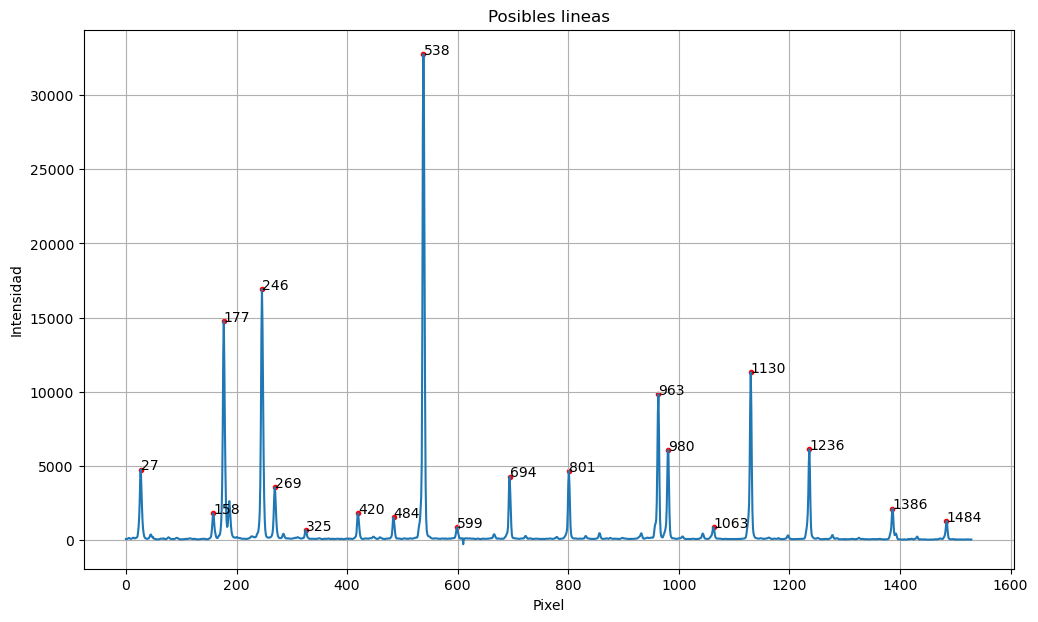

In [24]:
def Data(l):
    data = pd.read_csv(l, delimiter=' ')
    return data

def Spectrum(datax,datay):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>525) and (datax[i] != 187):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-7:i+7] )
                index_x.append( datax[i-7:i+7] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones

datos = Data(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt")
pixel = np.array(datos['P'])
intensidad = np.array(datos['I'])
marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad)

plt.figure(figsize=(12,7))
plt.plot(pixel,intensidad)
plt.scatter(marker_x,marker_y,marker='.',color = 'red')
plt.title('Posibles lineas')
plt.xlabel('Pixel')
plt.ylabel('Intensidad')
plt.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))
plt.show()

In [25]:
#Ajuste de Lorentz

def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)

def AjusteLorentz(i):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y

# plt.plot(fitx,fity, '--',color='b')
# plt.scatter(x,y)

Datafit = pd.DataFrame()
lineasfit = []
alturafit = []
anotacionesfit = []
anotacionesfit = []
catalog_long = [ 0, 0, 0, 6172.28, 0, 0, 6178.43, 0, 6182.62, 0, 0, 6191.91, 0, 6198.22, 0, 6203.49, 6207.22, 0, 0 ]


for i in range(0,19):
    linea,altura, fity, fitx, x, y = AjusteLorentz(i)
    lineasfit.append(linea)
    alturafit.append(altura)
    anotacionesfit.append(str(round(linea,1)))
    
Datafit['Pixel'] = lineasfit
Datafit['Instensidad'] = alturafit
Datafit['Catalogo longitud'] = catalog_long

Datafit

,Pixel,Instensidad,Catalogo longitud
0,26.739237,5001.843020,0.00
1,158.046697,1846.905788,0.00
2,177.003305,15353.197646,0.00
3,246.166012,17790.369569,6172.28
4,269.326072,3712.917835,0.00
5,325.240966,682.381533,0.00
6,419.733041,1940.658911,6178.43
7,483.937532,1615.436817,0.00
8,538.155621,35320.176747,6182.62
9,598.895878,875.488612,0.00


pixel     onda
246   - 6172.28
420   - 6178.43
538   - 6182.62
801   - 6191.91
980   - 6198.22
1130  - 6203.49
1235  - 6207.22

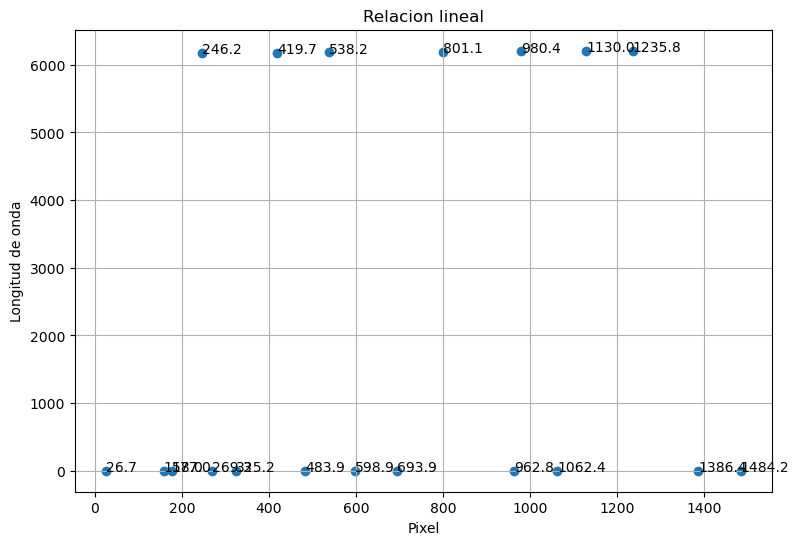

In [26]:
plt.figure(figsize=(9,6))
plt.scatter(Datafit['Pixel'],Datafit['Catalogo longitud'])

for i, label in enumerate(anotacionesfit):
    plt.annotate(label, (Datafit['Pixel'][i], Datafit['Catalogo longitud'][i]-10))
plt.title('Relacion lineal')
plt.grid()
plt.xlabel('Pixel')
plt.ylabel('Longitud de onda')
plt.show()
